In [ ]:
import random
import math
import time
import json
import os
from numba import jit

import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.mixture import GaussianMixture as GMM
from numpy.linalg import det as det

from utils import trws, restore_k

In [ ]:
img = np.array(Image.open("./lab4_data/alpaca.jpg"), dtype=np.float32)
m, n, c = img.shape
segm = np.array(Image.open("./lab4_data/alpaca-segmentation.png"), dtype=np.float32)
print("img.shape : ", img.shape, "; segm.shape : ", segm.shape)

###  First iteration

In [3]:
fg = img[segm.sum(axis=-1) > 0]
bg = img[segm.sum(axis=-1) == 0]
###
fgm = GMM(n_components=3).fit(fg)
fg_probs = fgm.weights_
fg_means = fgm.means_
fg_sigmas = fgm.covariances_
###
bgm = GMM(n_components=3).fit(bg)
bg_probs = bgm.weights_
bg_means = bgm.means_
bg_sigmas = bgm.covariances_

In [4]:
g = np.zeros((m, n, 4, 2, 2), dtype=np.float32)
gamma = 50
@jit(nopython=True)
def call_g(g, img, m, n, gamma):
    n_connections = 0
    beta = 0
    for i in range(m):
        for j in range(n):
            # up
            if i > 0:
                beta += np.linalg.norm(img[i, j, :] - img[i-1, j, :])**2
                n_connections +=1
            # down
            if i < m - 1:
                beta += np.linalg.norm(img[i, j, :] - img[i+1, j, :])**2
                n_connections +=1
            # left
            if j > 0:
                beta += np.linalg.norm(img[i, j, :] - img[i, j-1, :])**2
                n_connections +=1
            # right
            if j < n - 1:
                beta += np.linalg.norm(img[i, j, :] - img[i, j+1, :])**2
                n_connections +=1
    beta /= n_connections
    
    for i in range(m):
        for j in range(n):
            # up
            if i > 0:
                g[i, j, 0, 0, 1] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i-1, j, :])**2)/(2*beta)))
                g[i, j, 0, 1, 0] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i-1, j, :])**2)/(2*beta)))
            # down
            if i < m - 1:
                g[i, j, 1, 0, 1] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i+1, j, :])**2)/(2*beta)))
                g[i, j, 1, 1, 0] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i+1, j, :])**2)/(2*beta)))
            # left
            if j > 0:
                g[i, j, 2, 0, 1] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i, j-1, :])**2)/(2*beta)))
                g[i, j, 2, 1, 0] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i, j-1, :])**2)/(2*beta)))
            # right
            if j < n - 1:
                g[i, j, 3, 0, 1] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i, j+1, :])**2)/(2*beta)))
                g[i, j, 3, 1, 0] = np.exp(-gamma*np.exp(-(np.linalg.norm(img[i, j, :] - img[i, j+1, :])**2)/(2*beta)))
    
call_g(g, img, m, n, gamma)

In [5]:
q = np.zeros((m, n, 2), dtype=np.float32)
@jit(nopython=True)
def call_q(q, img, fg_probs, fg_means, fg_sigmas, bg_probs, bg_means, bg_sigmas, m, n):
    c = ((2*np.pi)**(5/2))
    for i in range(m):
        for j in range(n):
            for fg_index in range(len(fg_probs)):
                exp_value = np.exp(-0.5*(img[i, j, :] - fg_means[fg_index]).dot(np.linalg.inv(fg_sigmas[fg_index])).dot(img[i, j, :] - fg_means[fg_index]))
                q[i, j, 0] += fg_probs[fg_index]*c*np.sqrt(det(fg_sigmas[fg_index]))
            for bg_index in range(len(bg_probs)):
                exp_value = np.exp(-0.5*(img[i, j, :] - bg_means[bg_index]).dot(np.linalg.inv(bg_sigmas[bg_index])).dot(img[i, j, :] - bg_means[bg_index]))
                q[i, j, 1] += bg_probs[bg_index]*c*np.sqrt(det(bg_sigmas[bg_index]))
call_q(q, img, fg_probs, fg_means, fg_sigmas, bg_probs, bg_means, bg_sigmas, m, n)

<ipython-input-5-17301a89f406>:8: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 2d, A))
  exp_value = np.exp(-0.5*(img[i, j, :] - fg_means[fg_index]).dot(np.linalg.inv(fg_sigmas[fg_index])).dot(img[i, j, :] - fg_means[fg_index]))


In [6]:
C = np.array([0, 1])
start_time = time.time()
L, U, D, R, phi = trws(m, n, C, g, q)
end_time = time.time()
print(end_time - start_time)

116.94202780723572


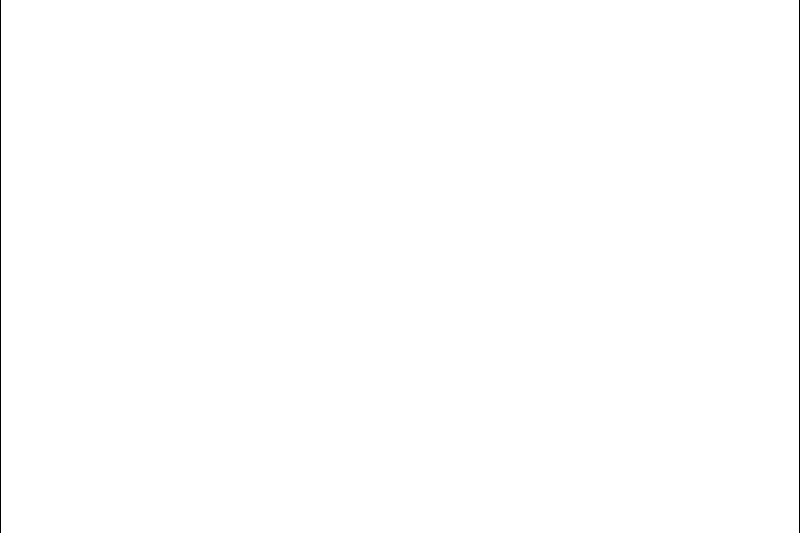

In [7]:
new_img = np.zeros((m, n), dtype=np.uint8)
for i in range(0, m):
    for j in range(1, n-1):
        new_img[i, j] = restore_k(i, j, C, L, R, q, phi)
Image.fromarray(new_img*255)